# Toronto Neighborhood Data Part 3: Exploration via Clustering

**1. Import Packages:**

In [2]:
import numpy as np
import pandas as pd
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Why does this part always take an hour to load...')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Why does this part always take an hour to load...


**2. Upload the previously preprocessed data on the geospatial coordinates of Toronto, ON, Canada:**

In [3]:
toronto_geospa=pd.read_csv('toronto_geospa.csv',index_col=0)
toronto_geospa.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


**3. Retrieve the latitude and longitude of 'Toronto, ON', to be used to for mapping. Use geocoder with a user_agent='Toronto_explorer':**

In [4]:
address='Toronto, ON'
geolocator=Nominatim(user_agent='Toronto_explorer')
location=geolocator.geocode(address)
lati=location.latitude
longi=location.longitude
"The location of Toronto, Ontario is {}, {}.".format(lati, longi)

'The location of Toronto, Ontario is 43.6534817, -79.3839347.'

**4. Create a map of Toronto with the data from canada_geospa superimposed over it:**

In [5]:
#Map layer of Toronto Coordinates:
map_toronto=folium.Map(location=[lati, longi], zoom_start=10)
#Superimpose the Toronto data onto this map:
for lat, long, bor, neigh in zip(toronto_geospa['Latitude'],toronto_geospa['Longitude'],toronto_geospa['Borough'],toronto_geospa['Neighborhood']):
    label='{} at {}'.format(neigh, bor) #added the 'at' since the Borough wasn't distinguishable enough
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='#6d2ed9', #purple is a nice color
        fill=True,
        fill_color='#c29eff',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)
#Display
map_toronto

**5. Downsize and visualize data only from Downtown, Toronto. I chose Downtown, Toronto since I want the most data later:**

In [6]:
DT_df=toronto_geospa[toronto_geospa['Borough']=='Downtown Toronto'].reset_index(drop=True)
DT_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


**6. Retrieve the latitude and longitude of 'Downtown, Toronto', to be used for mapping. Use geo_coder with user_agent='DT_explorer':**

In [7]:
DT_address='Downtown, Toronto'
DT_geolocator=Nominatim(user_agent='DT_explorer')
DT_loc=DT_geolocator.geocode(DT_address)
DT_lat=DT_loc.latitude
DT_long=DT_loc.longitude
'The geographical coordinate of Downtown, Toronto is {}, {}.'.format(DT_lat, DT_long)

'The geographical coordinate of Downtown, Toronto is 43.6541737, -79.38081164513409.'

**7. Map of Downtown, Toronto with its Neighborhoods superimposed:**

In [8]:
map_DT=folium.Map(location=[DT_lat, DT_long], zoom_start=11)
for lati, longi, labels in zip(DT_df['Latitude'], DT_df['Longitude'], DT_df['Neighborhood']):
    label=folium.Popup(labels, parse_html=True)
    folium.CircleMarker(
        [lati, longi],
        radius=5,
        popup=label,
        color='#ff9452', #switch to nice sunset orange
        fill=True,
        fill_color='#e8a456',
        fill_opacity=0.5,
        parse_html=False).add_to(map_DT)

map_DT

**8. Retrieve all of the top 100 venues in each neighborhood in Downtown, Toronto via Foursquare:**

**I have deleted the cell where I input my client_ID and client_secret for security reasons**, and I have replaced it with this cat:

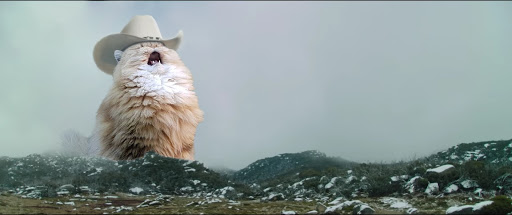

In [9]:
CLIENT_ID='0GDVEE5XYOYQO3F2E401SMKOHB0AGNBE4TENRDQ54SZH1MSG'
CLIENT_SECRET='RKZSGT5JUGRJO1TCH51J0PXXSY1GHXSWC1GAOJNVUY3QOTIN'
VERSION='20180605'

Create the function that will retrieve the top 100 venues in the neighborhoods of Downtown Toronto:

In [10]:
limit=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            long,
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function to get the data from the JSON files of each neighborhood:

In [11]:
DT_venues = getNearbyVenues(names=DT_df['Neighborhood'], latitudes=DT_df['Latitude'], longitudes=DT_df['Longitude'])

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [12]:
DT_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Trattoria Leonardo,43.652893,-79.525300,Italian Restaurant
1,"Regent Park, Harbourfront",43.654260,-79.360636,Montgomery's Inn Museum,43.651831,-79.525597,History Museum
2,"Regent Park, Harbourfront",43.654260,-79.360636,Kingsway Offleash Dig Park,43.651777,-79.517483,Dog Run
3,"Regent Park, Harbourfront",43.654260,-79.360636,Lenny's,43.652753,-79.525515,Italian Restaurant
4,"Garden District, Ryerson",43.657162,-79.378937,Bulk Barn,43.660939,-79.517773,Supermarket


**9. Count the unique types of venues:**

In [13]:
'Downtown Toronto has {} unique venue types!'.format(len(DT_venues['Venue Category'].unique()))

'Downtown Toronto has 44 unique venue types!'

In [14]:
DT_venues.shape

(163, 7)

163 venues!

**10. Let us look at the occurence of "Venue Category" by each "Neighborhood" in Downtown Toronto. Use one hot encoding so the data can be processed easier by machine learning by turning categorical variables into nominal variables:**

In [15]:
DT_hot=pd.get_dummies(DT_venues[['Venue Category']], prefix="", prefix_sep="")
DT_hot['Neighborhood']=DT_venues['Neighborhood']
DT_hot=DT_hot[[DT_hot.columns[-1]]+list(DT_hot.columns[:-1])]
DT_hot.head()

,Neighborhood,Bakery,Bank,Beer Store,Burger Joint,Bus Line,Bus Stop,Camera Store,Caribbean Restaurant,Coffee Shop,...,Sandwich Place,Shopping Mall,Skating Rink,Spa,Supermarket,Supplement Shop,Tanning Salon,Thai Restaurant,Wings Joint,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Garden District, Ryerson",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


**11. Let us take the mean frequency of each "Venue Category" per "Neighborhood":**

In [16]:
DT_hot_mean=DT_hot.groupby('Neighborhood').mean().reset_index()
DT_hot_mean.head()

,Neighborhood,Bakery,Bank,Beer Store,Burger Joint,Bus Line,Bus Stop,Camera Store,Caribbean Restaurant,Coffee Shop,...,Sandwich Place,Shopping Mall,Skating Rink,Spa,Supermarket,Supplement Shop,Tanning Salon,Thai Restaurant,Wings Joint,Yoga Studio
0,Berczy Park,0.058824,0.000000,0.058824,0.000000,0.0,0.000000,0.000000,0.058824,0.176471,...,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.0
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.076923,0.000000,0.000000,0.076923,0.0,0.000000,0.000000,0.000000,0.000000,...,0.076923,0.0,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.076923,0.0
2,Central Bay Street,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,...,0.000000,0.0,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.0
3,Christie,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Church and Wellesley,0.111111,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,...,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


**12. Now let us use the mean frequency to find out which "Venue Category" is most likely to be found in which "Neighborhood":**

In [17]:
#function for descending order
def ordered_venues(row, top_ten):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending=False)
    
    return row_cat_sorted.index.values[0:top_ten]
#adding suffixes/ordinal names to the column ranking (1st, 2nd, 3rd, ..., etc.)
top_ten=10
col=['Neighborhood']
suffixes=['st', 'nd', 'rd']
for suff in np.arange(top_ten):
    try:
        col.append('{}{} Most Common Venue'.format(suff+1, suffixes[suff]))
    except:
        col.append('{}th Most Common Venue'.format(suff+1))
#lets start sorting in a new DataFrame
DT_venues_sorted=pd.DataFrame(columns=col)
DT_venues_sorted['Neighborhood']=DT_hot_mean['Neighborhood']
for i in np.arange(DT_hot_mean.shape[0]):
    DT_venues_sorted.iloc[i, 1:]=ordered_venues(DT_hot_mean.iloc[i, :], top_ten)
DT_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Pub,Fast Food Restaurant,Sandwich Place,Eastern European Restaurant,Japanese Restaurant,Pizza Place,Caribbean Restaurant,Restaurant,Bakery
1,"CN Tower, King and Spadina, Railway Lands, Har...",Bakery,Sandwich Place,Wings Joint,Grocery Store,Flower Shop,Fast Food Restaurant,Discount Store,Convenience Store,Hardware Store,Gym
2,Central Bay Street,Ice Cream Shop,Spa,Liquor Store,Pharmacy,Restaurant,Camera Store,Grocery Store,Supermarket,Bank,Bus Line
3,Christie,Bus Stop,Park,Fast Food Restaurant,Yoga Studio,Discount Store,Gym,Grocery Store,French Restaurant,Flower Shop,Eastern European Restaurant
4,Church and Wellesley,Ice Cream Shop,Pharmacy,Bus Stop,Convenience Store,Grocery Store,Japanese Restaurant,Park,Bakery,Skating Rink,Shopping Mall


All these different restaurant types are making me hungry. Berczy Park is my kind of place, with Coffee Shops and Pubs most likely occuring.

**13. Now I will use k-means clustering to visualize the spread of all these venues by neighborhood:**

In [18]:
#choose 5 centroids
kay=5
DT_hot_mean_cluster=DT_hot_mean.drop('Neighborhood', 1)
DT_hot_mean_cluster.head()
kmeans=KMeans(n_clusters=kay, random_state=0).fit(DT_hot_mean_cluster)
kmeans.labels_[0:10]

array([0, 0, 2, 3, 3, 0, 0, 2, 0, 1])

Merge the clusters, ranking, and Downtown Toronto data:

In [19]:
DT_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged_DT_df=DT_df
merged_DT_df=DT_df.join(DT_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
merged_DT_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Italian Restaurant,History Museum,Dog Run,Yoga Studio,Gym,Grocery Store,French Restaurant,Flower Shop,Fast Food Restaurant,Eastern European Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Bank,Supermarket,Spa,Camera Store,Yoga Studio,Discount Store,Gym,Grocery Store,French Restaurant,Flower Shop
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Italian Restaurant,Pizza Place,Construction & Landscaping,History Museum,Yoga Studio,Dog Run,Gym,Grocery Store,French Restaurant,Flower Shop
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Pub,Fast Food Restaurant,Sandwich Place,Eastern European Restaurant,Japanese Restaurant,Pizza Place,Caribbean Restaurant,Restaurant,Bakery
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Ice Cream Shop,Spa,Liquor Store,Pharmacy,Restaurant,Camera Store,Grocery Store,Supermarket,Bank,Bus Line


**14. Use the merged DownTown Toronto Dataframe to view the clusters with centroid=5:**

In [20]:
DT_clusters = folium.Map(location=[DT_lat, DT_long], zoom_start=11)
x = np.arange(kay)
ys = [i + x + (i*x)**2 for i in range(kay)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lati, long, neigh, cluster in zip(merged_DT_df['Latitude'], merged_DT_df['Longitude'], merged_DT_df['Neighborhood'], merged_DT_df['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lati, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(DT_clusters)
       
DT_clusters

# Conclusion:

I think k-means clustering associated different neighborhoods into groups depending on their different features, specifically different venue categories. In other words this last map shows neighborhoods that are the same based on the type of venues they have. **Although, I'm not sure if the k-value or centroid value is correct. Can we find the best k-value the same way we find k-value for KNN?** Also, why not use DBSCAN? It seems that the venue categories (features) can be in the same radius of different locations/neighborhoods. Wouldn't overlap interfere with association? All-in-all, I understand the process, but I still have alot of questions.